# No groups

Now we dont have information about the group


# Parallel Tempering

In the following code, we created four networks using the generative model with probability of error in copying links and no links. We set the blueprint as A2, because is the one with the bigger number of connections

In this notebook we are not working with weighted networks, only with the presence or not of a connection (Binary adjacency matrices).



In [2]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

# DATASET

In [3]:
### Open the files
tablas = 8
n_grupo = 4

d = {}
D = "Dataset"
for i in range(0,tablas):
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1))
    print('Read:',i, 'size', d["group" + str(i)].shape)

Read: 0 size (227, 183)
Read: 1 size (227, 183)
Read: 2 size (227, 183)
Read: 3 size (227, 183)
Read: 4 size (227, 183)
Read: 5 size (227, 183)
Read: 6 size (227, 183)
Read: 7 size (227, 183)


In [4]:
## Hipermatrix M with the data (Only the synapses) 
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3

M = np.zeros((tablas,rows,columns))
for i in range(0, tablas):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]
    
## Since we work with same number of nodes, we want them equal and square (zeros when no connections)
M_square = np.zeros((tablas, rows, rows))
M_square[:,:, 0:columns] = M[:,:,:]

## Binarization: No weights
#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_square_bin = np.zeros((tablas,rows,rows))
for i in range(tablas):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_square_bin[i,j,k] = 1
                
Nx = rows # Number of nodes (we imposed rows == columns)

### GROUP INFORMATION

No groups.

Por ahora dejo los grupos, luego lo quitare

In [5]:
n_groups = 1
start_groups = np.zeros(1)
end_groups = np.zeros(1) + Nx
size_groups = np.zeros(1) + Nx

start_groups, end_groups, size_groups = start_groups.astype(int), end_groups.astype(int), size_groups.astype(int)

## ENERGY FUNCTIONS



In [6]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo



## INITIAL CONDITIONS

We will align the four networks from A2. They have the same number of errors iin links and no links (so the probability of copying bad a no-link is smaller)

In [7]:
Nx = rows # Nodes
K = 2 # Number of networks
alpha,beta = 5,2 # Values for the beta prior distribution 


Edges = Nx*Nx 
micropasos = Edges*K #Microsteps for each MCMC
A = np.zeros((K,Nx,Nx))

##Copying process
np.random.seed(np.random.randint(1,1000))
e_error = 327 # Miscopied edges
z_error = 327 # Miscopied no-edges
L_original = M_square_bin[-1, :,:] # A2 as the blueprint in  the generative model
for m1 in range(K):
    A[m1,:,:] = L_original.copy()
    A_array = np.reshape(A[m1,:,:], (Nx*Nx))
    # Error copy edge
    for i_e in range(e_error):
        posi = np.random.randint(len( np.where(A_array == 1)[0] ))
        A_array[posi] = 0
    # Error copy zero
    for i_z in range(z_error):
        posi = np.random.randint(len(np.where(A_array == 0)[0]))
        A_array[posi] = 1
    A[m1,:,:] = np.reshape(A_array, (Nx,Nx))
    
d_store={}
string = "Matriz_epochs_A.pickle"
d_store["A"] = A
file1 = open(string,"wb")
pickle.dump( d_store, file1)
file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))
####################################

## INITIALIZATION ##

L_ini = np.zeros((Nx,Nx))
P_ini_0 = np.zeros((K,Nx))
P_inv_ini_0 = np.zeros((K,Nx))

# We inizialize with the Blueprint = L2
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx)) #Groups label
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g
        
## Overlaps
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)

        
# Inizialization according to node-degree (taking into account group labels)
P_inis = permu_groups(L_ini, A, start_groups)
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
print('*************************')
print(P_ini_0[:,:10])

*************************
[[  0   1   2   3   4   5   6   7   8   9]
 [151  62 178  57 214 202  94   6 211  35]]


## Temperatures

We are permorfing a Parallel tempering Markov Chain MonteCarlo

We run our MCMC at difference temperatures (proposing changes between them), and we will sample at temper = 1

In [8]:
# Temperature distributin
beta_o = 1.03
total = 15 # Odd name, in order to have beta = 1
b_exp = np.linspace(-5,5,num = total)
tempers = beta_o**b_exp # Account for 1/KT, called beta in thermodinamics
print('betas:', tempers)
N_t = len(tempers)

## Inizialitation of the system for each temperature, with the same mappings
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Nx)) 
groups_ini_t = np.zeros((N_t, K, Nx ))

for i in range(0,N_t): 
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()


betas: [0.86260878 0.88101504 0.89981405 0.91901419 0.93862401 0.95865228
 0.9791079  1.         1.0213379  1.0431311  1.06538932 1.08812249
 1.11134073 1.1350544  1.15927407]


# MONTE CARLO FUNCTIONS 

Probably some functions are easy to optimize.


In [9]:
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@njit
def numba_choice():
    random_val = random.randint(0, 1)  # Generate a random integer between 0 and 1
    return 2 * random_val - 1

In [10]:
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def

In [11]:
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    ## ROWS
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        for i_x in range(Nx):
            if (i_x not in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
            
                    
    ## COLUMNS 
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                L_c_v1v2[j_j,i_x] = round( valor_lnew_2)

                    
            else: # the changes are the same as the columns
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1

In [12]:
@jit(nopython = True)
def parallel_L_knwn_change(c_parallel,alpha,beta,fijado_f,groups_f, N_groups_f, start_f, end_f,
                       A, P_t_f, P_inv_t_f, L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f):
    
    # fijado_f : To let one of the networks fixed or not (If only two networks it doesn't matter)
    # c_parallel: counter to change temperatures
    # start_f, end,f
    # N_groups_f: Number of groups
    # groups_f: Directly the ggroup numbeer from the position
    
    ### Movement:
    # 1) Choose one node and see their group (also we can choose a group first)
    # 2) Choose another random node inside this group 
    # 3) Each 4 movements, we propose change the temperatures

    N_t = L_t_f.shape[0] # Numbers of tempers
    Nx = L_t_f.shape[1] # Numbers of nodes
    K = A.shape[0] # Numbers of networks
    Edges_sum = K*Nx*Nx
   
    if (c_parallel <4*Nx): # If not change of temperatures
        c_parallel += 1
        
        #Choose the networks to propose the change (in all temperatures)
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #One networks
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):            
            # 1) Choose a random node (node in A)
            v1_mapping = np.random.randint(start_f[0], Nx)
            # Inside the group:
            grupo = groups_f[k_nt,m1,v1_mapping]
            start, end = start_f[grupo], end_f[grupo]
            size_group = end - start
            todos = size_group 
            if (size_group > 1): 

                v2_mapping = np.random.randint(start, end)
                while (v2_mapping == v1_mapping):
                    v2_mapping = np.random.randint(start, end)

                # Nodes in L
                v1 = P_t_f[k_nt, m1,v1_mapping]
                v2 = P_t_f[k_nt, m1, v2_mapping]


                ### Only changes in the specific columns and rows
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))

                pp_1 = int(P_inv_t_f[k_nt,m1,v2]) # v2_mapping
                pp_2 = int(P_inv_t_f[k_nt,m1,v1]) # v1_mapping
                
                # Changes in the blueprint
                L_f_v1v2,L_c_v1v2 , suma_aux = L_wiring_change_filas(m1,L_t_f[k_nt,:,:], A, v1, v2, P_inv_t_f[k_nt,:,:])
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:].copy(),L_t_f[k_nt,v2,:].copy()
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1].copy(),L_t_f[k_nt,:,v2].copy()
                
                # Parameters to change
                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                ovl_0_new, ovl_1_new = overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2 ,A,P_inv_t_f[k_nt,:,:], v1,v2, pp_1, pp_2)
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler


                ### UPDATE
                if (dE_t < 0):
                    
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):

                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

    else: # Change in temperatures
        c_parallel = 0 
        mt1 = np.random.randint(N_t)  #temper 1
        mt2 =  mt1 + numba_choice()#temper 2
        while (mt1 == mt2):
            mt2 =  mt1 + numba_choice()
        if (mt2 == N_t ):
            mt2 = N_t-2
        
        Energy_1 = Energy_t_f[mt1]
        Energy_2 = Energy_t_f[mt2] 


        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <0):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L, groups_f

# Running MonteCarlo

In [13]:
fijado = 0 # To maintain fix the first network

In [14]:
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Nx)) 
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')


Energy with the reference mapping: 3843.714015799884
overlap_0: 95360 /overlap_1: 4358
%Overlaps: 99.36822385204081 %


In [15]:
np.random.seed( random.randint(1,1999))
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Nx))
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # edges=1 in A
Edges_NoL = Edges_sum - Edges_L # edges=0 in A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')


# VARIABLE USING INITIAL CONDITIONS
P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Nx))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
groups_t = np.zeros((N_t, K, Nx))
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
groups_t = groups_ini_t.copy()
#Integer variables
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
groups_t = groups_t.astype(int)

## Initial energy with L = A[0]
Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()
print('Initial energy with L = A[0]:', Energy_ini)
print()


#### Now the Blueprint is averaged
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
print('Energy with L_wiring:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')

Energy_ini_wiring = Energy_t.copy()
suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])


### MONTE CARLO
# Parameters
PasosMC = 1000
Long_corr = 500
Pasos_corr = 2000
Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
steps_middle_0 = 500
steps_middle_1 = 1000
    
# Variables to store    
energies_pasos = np.zeros((N_t,PasosMC))
energies_pasos[:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0
P_store = np.zeros((Pasos_store,N_t, K, Nx))
groups_store = np.zeros((Pasos_store, N_t,K,Nx))
Energy_store = np.zeros((Pasos_store, N_t))
L_store = np.zeros((Pasos_store,N_t, Nx, Nx))
P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))


#######################################
start = time.time()
count_parallel, count_long, i_long = 0,0,0
for i_mc in tqdm(range(0,PasosMC)):
    ## Starting to store sampling configurations
    if (i_mc > Pasos_corr):
        count_long += 1
        if (count_long == Long_corr):
            count_long = 0
            P_store[i_long,:,:,:] = P_t.copy()
            Energy_store[i_long,:] = Energy_t.copy()
            L_store[i_long,:,:,:] = L_t.copy()
            groups_store[i_long, :,:] = groups_t.copy()
            i_long += 1
            print('Step', i_mc, 'Energy (temper = 1):', Energy_t[4])
    
    ## Store transient configurations
    if (i_mc == steps_middle_0 ):
        P_intermediate_shot[0,:,:,:] = P_t.copy()
        E_intermediate_shot[0,:] = Energy_t.copy()
    if (i_mc == steps_middle_1 ):
        P_intermediate_shot[1,:,:,:] = P_t.copy()
        E_intermediate_shot[1,:] = Energy_t.copy()


    energies_pasos[:, i_mc] = Energy_t[:]
    for i_micro in range(Nx):

        count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t, groups_t = parallel_L_knwn_change( count_parallel,alpha,beta,fijado,groups_t,n_groups, start_groups, 
                                                                                                 end_groups, A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                 ovlp_t1, tempers)

                                                                                                  
end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

## Final energy
Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energy final:', Energy_t, '/Computed final:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



Energy with the reference mapping: 3843.714015799884
overlap_0: 95360 /overlap_1: 4358
%Overlaps: 99.36822385204081 %

Initial energy with L = A[0]: 62.332894580293214

Energy with L_wiring: 18627.013931763962
overlaps 0: 95360 1: 408
%Overlaps: 95.43207908163265 %


  3%|█                                        | 27/1000 [00:07<04:38,  3.49it/s]


SystemError: CPUDispatcher(<function parallel_L_knwn_change at 0x7fe3335efd90>) returned a result with an exception set

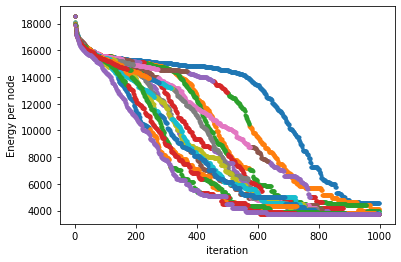

In [39]:
x=np.arange(PasosMC)
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
# plt.legend()
plt.show()

In [ ]:
### Voy a construir un diccionario para guardar todo
d_store={}
string = "prueba.pickle"
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups

d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
d_store["L_store"] = L_store

d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
# prueba = pickle.load(open(string, "rb"))

In [16]:
# Voy a construir un diccionario para guardar todo
d_store={}
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups



d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
d_store["L_store"] = L_store

d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))


In [17]:
len(tempers)

15